In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms

In [2]:
train_features = pd.read_csv("data/train_features.csv", index_col="id")
test_features = pd.read_csv("data/test_features.csv", index_col="id")
train_labels = pd.read_csv("data/train_labels.csv", index_col="id")

In [3]:
train_labels.head()

antelope_duiker  bird  blank  civet_genet  hog  leopard  \
id                                                                  
ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   

          monkey_prosimian  rodent  
id                                  
ZJ000000               0.0     0.0  
ZJ000001               1.0     0.0  
ZJ000002               0.0     0.0  
ZJ000003               1.0     0.0  
ZJ000004               0.0     0.0

In [5]:
train_features.head()

filepath   site
id                                          
ZJ000000  train_features/ZJ000000.jpg  S0120
ZJ000001  train_features/ZJ000001.jpg  S0069
ZJ000002  train_features/ZJ000002.jpg  S0009
ZJ000003  train_features/ZJ000003.jpg  S0008
ZJ000004  train_features/ZJ000004.jpg  S0036

In [6]:
test_features.head()

filepath   site
id                                         
ZJ016488  test_features/ZJ016488.jpg  S0082
ZJ016489  test_features/ZJ016489.jpg  S0040
ZJ016490  test_features/ZJ016490.jpg  S0040
ZJ016491  test_features/ZJ016491.jpg  S0041
ZJ016492  test_features/ZJ016492.jpg  S0040

In [8]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

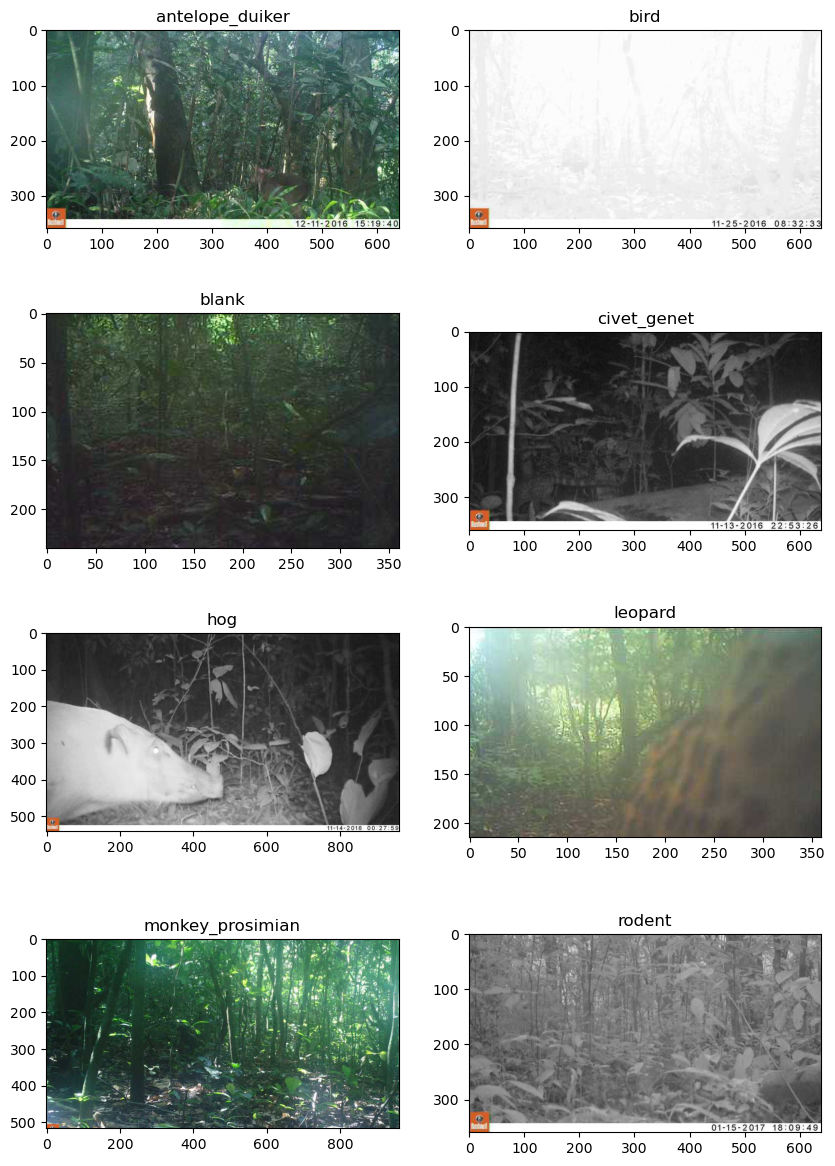

In [37]:
random_state = 23

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

for species, ax in zip(species_labels, axes.flat):

    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = Image.open("data/" + train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(species)

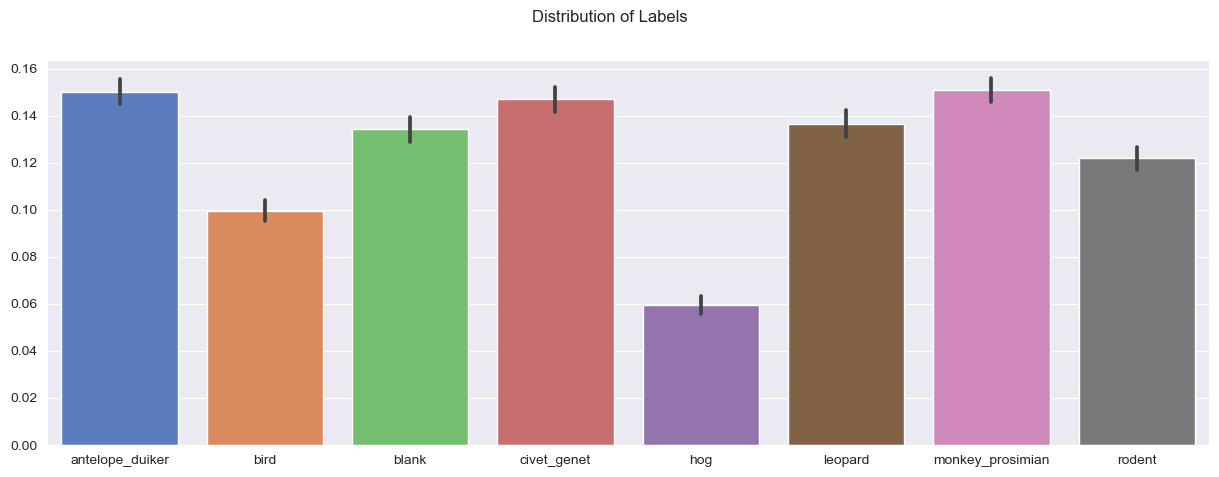

In [93]:
fig = plt.figure(figsize=(15, 5))
sns.set_palette("muted")
sns.barplot(data=train_labels)
fig.suptitle("Distribution of Labels")
plt.show()

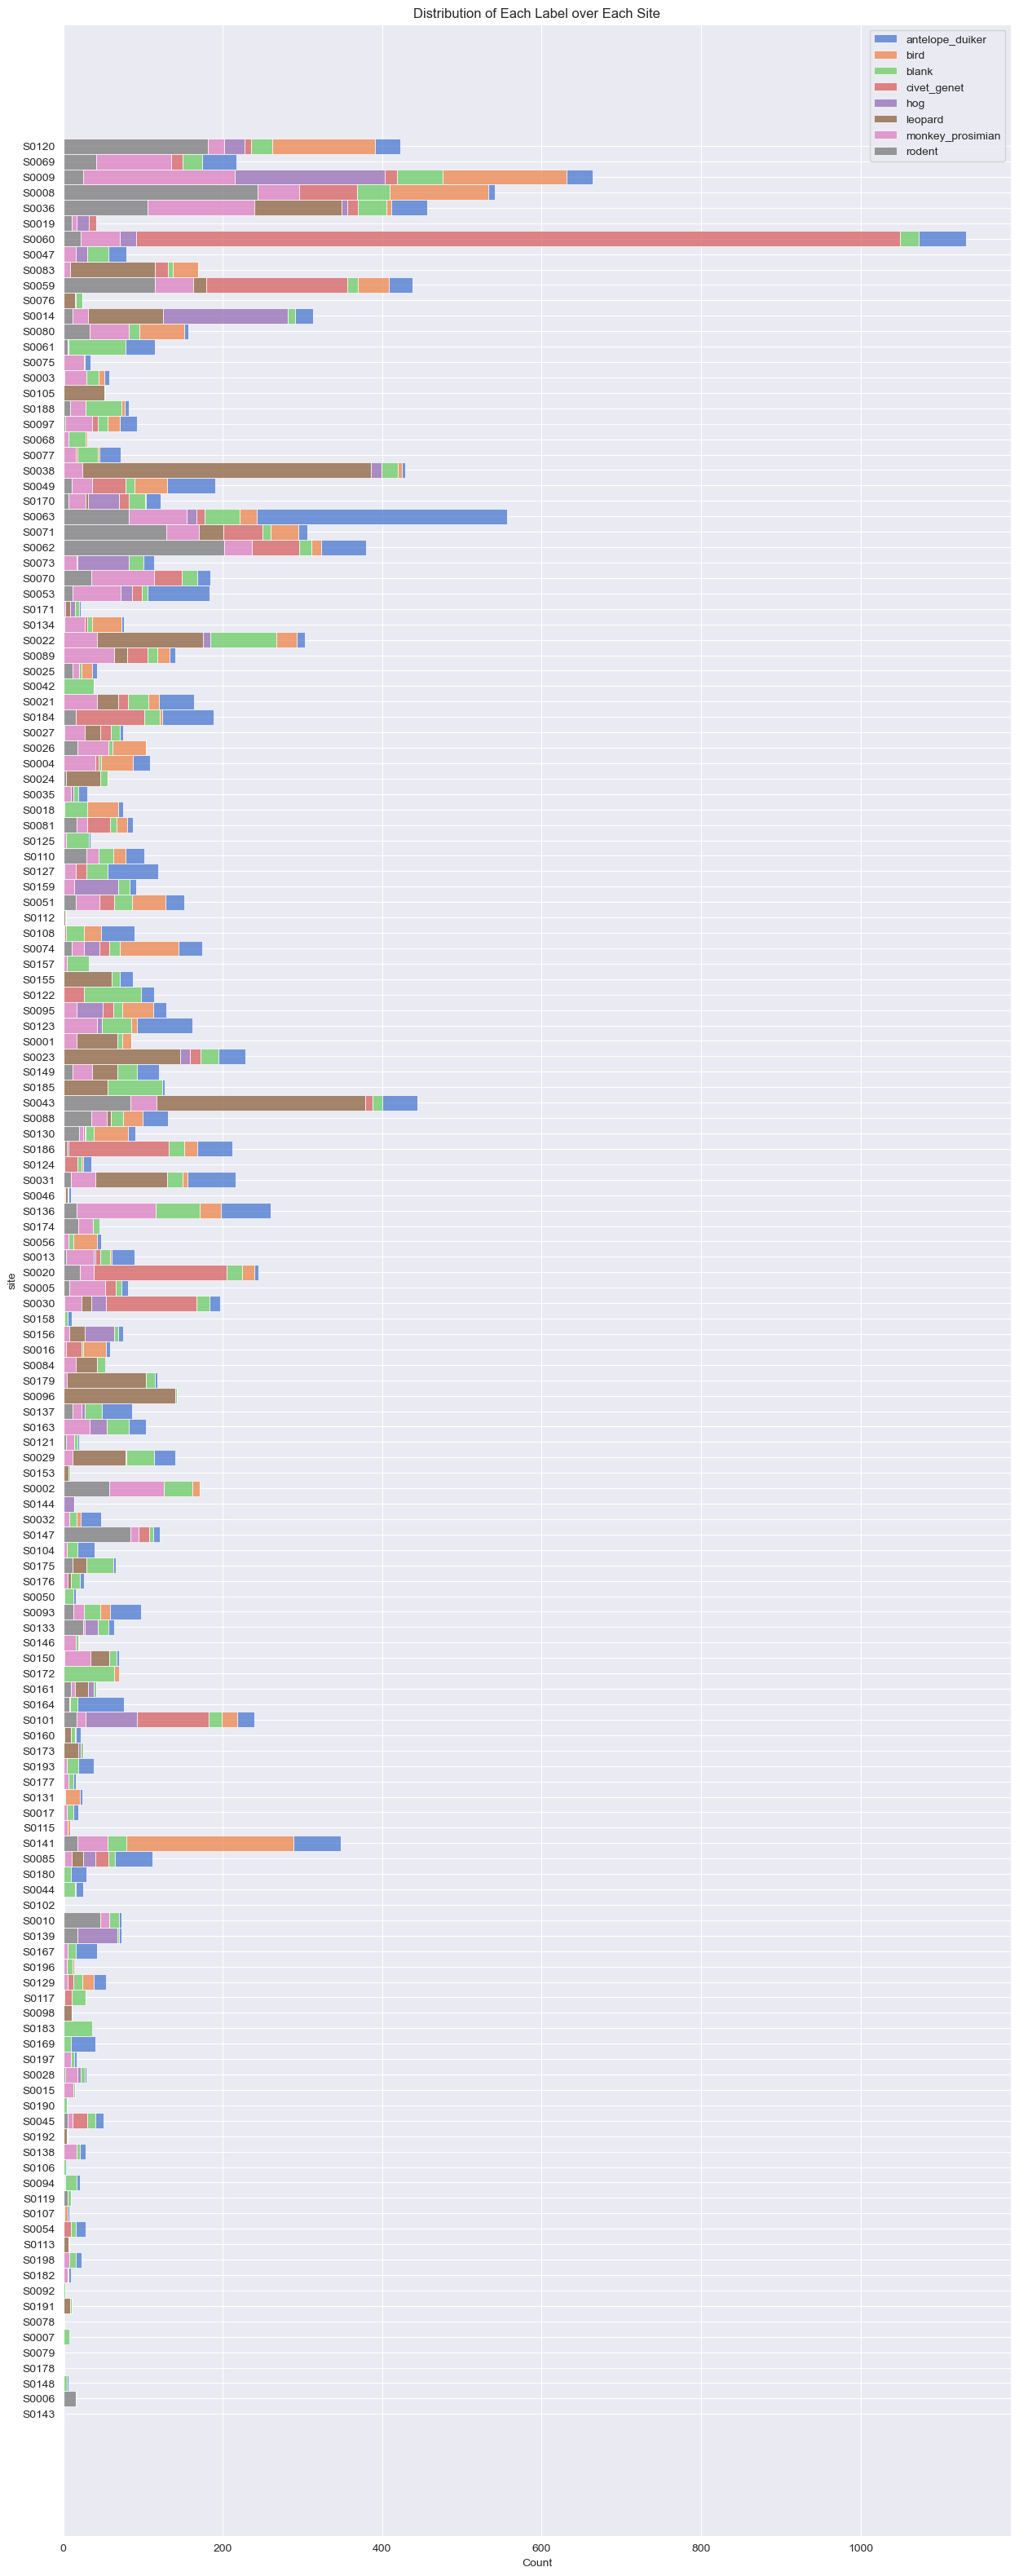

In [95]:
f, ax = plt.subplots(figsize=(15, 40))
sns.set_style("darkgrid")
sns.set_palette("muted")
sns.histplot(data = train_labels.join(train_features, on="id"),
            y="site", hue=train_labels.idxmax(axis=1), multiple="stack", linewidth=.5,
             hue_order=["antelope_duiker", "bird", "blank", "civet_genet", "hog", "leopard", "monkey_prosimian", "rodent"])
ax.set_title("Distribution of Each Label over Each Site")
plt.show()

In [4]:
class ConserVisionDataset(Dataset):

    def __init__(self, features_df, labels_df=None, transform=None):
        self.features_df = features_df
        self.labels_df = labels_df
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open("data/" + self.features_df.iloc[index]["filepath"]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        image_id = self.features_df.index[index]
        site = self.features_df["site"][index]

        if self.labels_df is not None:
            label = torch.tensor(self.labels_df.iloc[index].values, dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "site": site,
                      "label": label, "top_label": self.labels_df.idxmax(axis=1)[index]}
        else:
            sample = {"image_id": image_id, "image": image, "site": site}
        return sample

    def __len__(self):
        return len(self.features_df)

In [313]:
train_dataset = ConserVisionDataset(train_features, labels_df=train_labels, transform=None)

In [314]:
augmentation = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.ColorJitter(.7, .5, .5, (-0.15, 0.3)),
                    transforms.RandomAdjustSharpness(1.5, 0.2),
                    transforms.RandomAdjustSharpness(0.1, 0.2),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.RandomGrayscale(1), transforms.RandomInvert(0.5)]), 0.2),
                ])

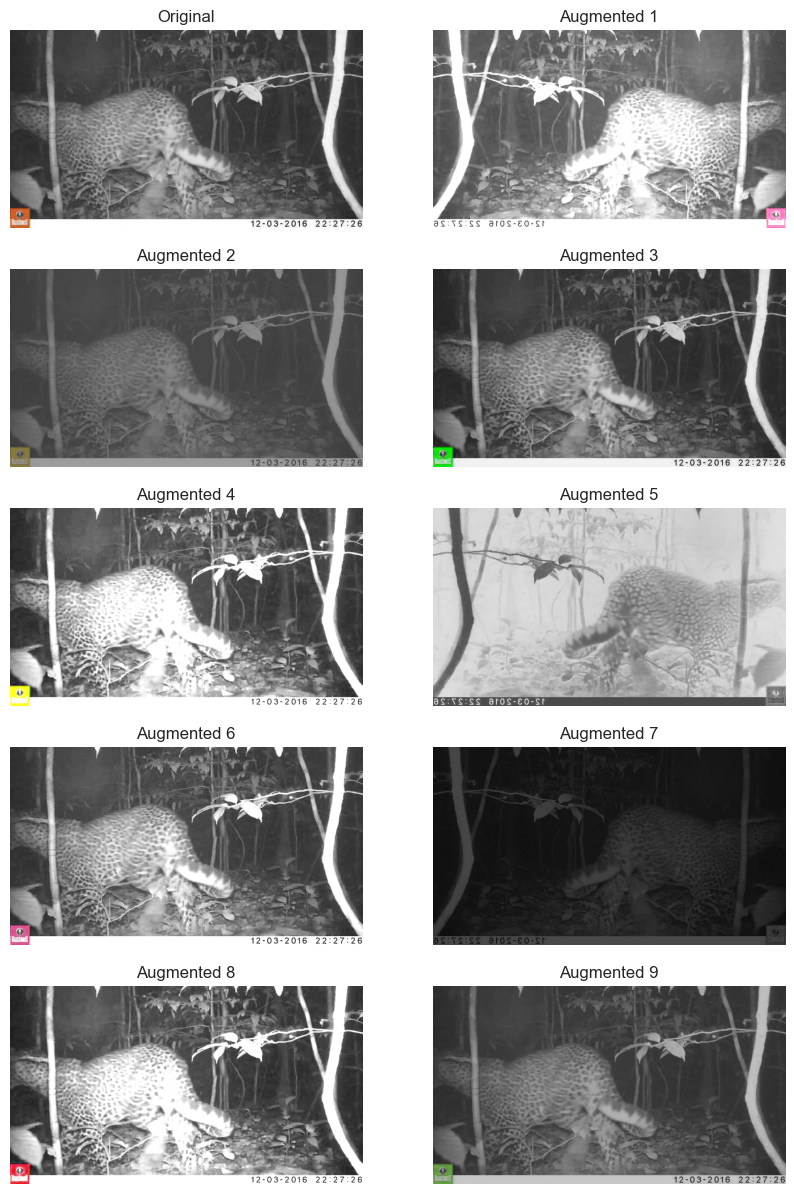

In [308]:
example = train_dataset[1983]
figure = plt.figure(figsize=(10, 15))

plt.subplot(5, 2, 1)
plt.axis("off")
plt.imshow(example["image"])
plt.title("Original")

for i in range(2, 11):
    plt.subplot(5, 2, i)
    plt.axis("off")
    plt.imshow(augmentation(example["image"]))
    plt.title(f"Augmented {i-1}")
plt.show()

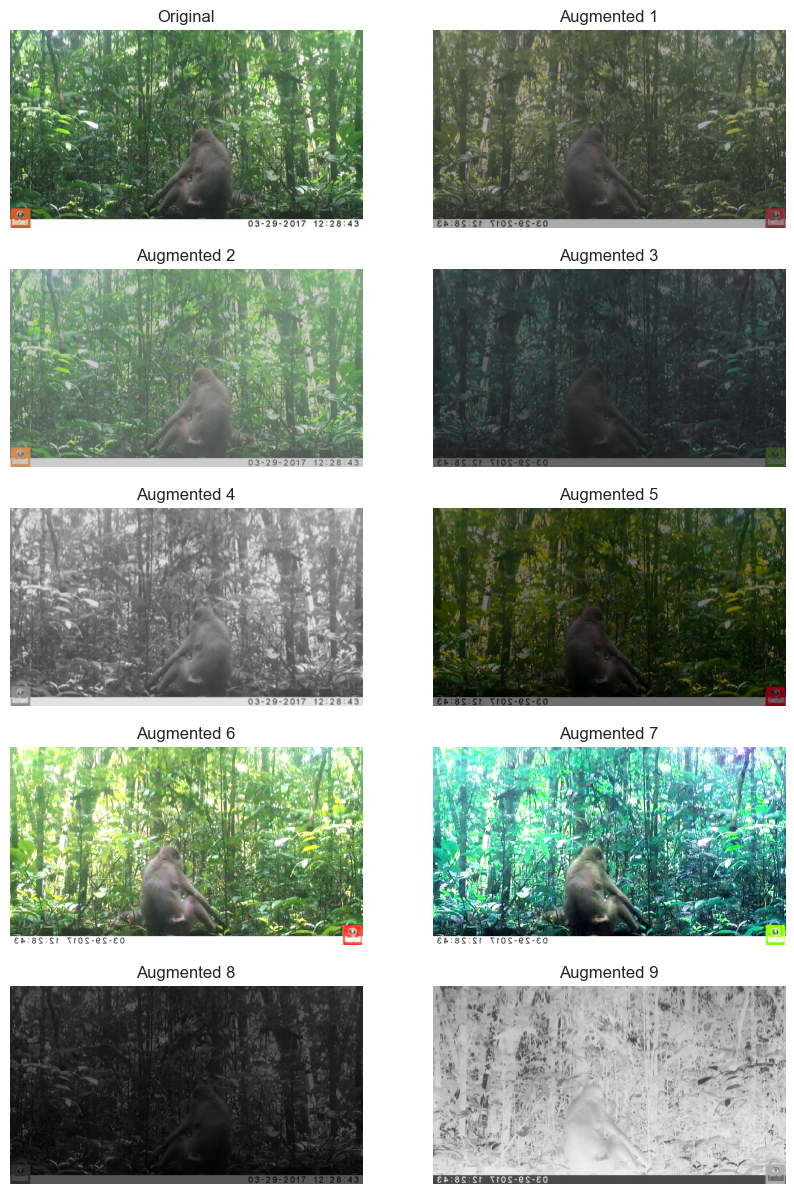

In [356]:
example = train_dataset[7211]
figure = plt.figure(figsize=(10, 15))

plt.subplot(5, 2, 1)
plt.axis("off")
plt.imshow(example["image"])
plt.title("Original")

for i in range(2, 11):
    plt.subplot(5, 2, i)
    plt.axis("off")
    plt.imshow(augmentation(example["image"]))
    plt.title(f"Augmented {i-1}")
plt.show()

In [310]:
transform = transforms.Compose(
            [
                augmentation,
                transforms.Resize((240, 240)),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])

In [311]:
train_dataset.transform = transform